# Final model 
## Merged file including work from Angela, Louis and Matthew

## Section 1.) Modeling Construction and Optimization

In [1]:
# Importing correct packages
import pandas as pd
import numpy as np
pd.set_option('display.max_columns', None)

# Machine Learning Libraries
import lightgbm as lgb
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# API Packages
from datetime import date
import re
from datetime import datetime,timedelta
import requests
import json

# Data Drift Packaging
#from alibi_detect.cd import TabularDrift
#from alibi_detect.cd import ClassifierDrift
#import tensorflow as tf
#from tensorflow import keras

# Unit Test Packaging
import treon
import unittest
import pickle

# Figures
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_theme(style="whitegrid")

from sklearn.metrics import (
    confusion_matrix, 
    accuracy_score, 
    precision_recall_curve,
    average_precision_score,
    roc_curve,
    roc_auc_score,
    classification_report,
    plot_confusion_matrix
)

In [2]:
# Importation of Revised Dataset from April 10th, 2022
df = pd.read_csv("/Users/matthewbuttlerives/Desktop/Data Folder/Period_1_Game_Stats_Final_ModelReady(April-10th-2022).csv")
df.head()

,won,Shots,Shots_Against,Goals,Goals_Against,Takeaways,Takeaways_Against,Hits,Hits_Against,Blocked Shots,Blocked Shots Against,Giveaways,Giveaways_Against,Missed Shots,Missed Shots_Against,Penalities,Penalities_Against,#Won Faceoffs,#Lost Faceoffs,HoA_away,HoA_home
0,0,8.0,8.0,0.0,3.0,1.0,3.0,14.0,5.0,3.0,3.0,6.0,7.0,4.0,0.0,1.0,1.0,10.0,12.0,1,0
1,1,8.0,8.0,3.0,0.0,3.0,1.0,5.0,14.0,3.0,3.0,7.0,6.0,0.0,4.0,1.0,1.0,12.0,10.0,0,1
2,1,11.0,12.0,0.0,1.0,0.0,2.0,4.0,4.0,6.0,8.0,2.0,0.0,6.0,3.0,1.0,3.0,11.0,9.0,1,0
3,0,12.0,11.0,1.0,0.0,2.0,0.0,4.0,4.0,8.0,6.0,0.0,2.0,3.0,6.0,3.0,1.0,9.0,11.0,0,1
4,1,9.0,8.0,0.0,1.0,3.0,2.0,4.0,5.0,7.0,1.0,7.0,5.0,3.0,8.0,2.0,1.0,7.0,11.0,1,0


In [3]:
# split data into X and y
y = df.pop('won')
X = df

# split data into train and test sets
seed = 7
test_size = 0.33
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=seed)

In [4]:
# Final Lightgbm.LGBMClassifier model
final_model = lgb.LGBMClassifier(learning_rate=0.04, max_depth=10, num_leaves = 31, random_state=42)
final_model.fit(X_train,y_train)
final_model.score(X_test, y_test)

0.6608801583675955

In [5]:
# Accuracy Scores
print('Training accuracy {:.4f}'.format(final_model.score(X_train,y_train)))
print('Testing accuracy {:.4f}'.format(final_model.score(X_test,y_test)))

Training accuracy 0.7156
Testing accuracy 0.6609


In [6]:
# Accuracy, Precision and Recall Scores
from sklearn.metrics import precision_score, recall_score
y_pred = final_model.predict(X_test)
predictions = [round(value) for value in y_pred]
accuracy = accuracy_score(y_test, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))
print('Precision score: ', (precision_score(y_test, predictions)))
print('Recall score: ', recall_score(y_test, predictions))

Accuracy: 66.09%
Precision score:  0.6652347345811599
Recall score:  0.6561743341404358


In [7]:
# Define some helpful functions
def clf_score(clf, X_train, y_train, X_val, y_val, train=True):
    if train:
        print("Train Result:\n")
        print("accuracy score: {0:.4f}\n".format(accuracy_score(y_train, clf.predict(X_train))))
        print("Classification Report: \n {}\n".format(classification_report(y_train, clf.predict(X_train))))
        print("Confusion Matrix: \n {}\n".format(confusion_matrix(y_train, clf.predict(X_train))))

        res = cross_val_score(clf, X_train, y_train, cv=10, scoring='accuracy')
        print("Average Accuracy: \t {0:.4f}".format(np.mean(res)))
        print("Accuracy SD: \t\t {0:.4f}".format(np.std(res)))

    elif train == False:
        print("Validation Result:\n")
        print("accuracy score: {0:.4f}\n".format(accuracy_score(y_val, clf.predict(X_val))))
        
        precision, recall, _ = precision_recall_curve(y_val, clf.predict(X_val))
        average_precision = average_precision_score(y_val, clf.predict(X_val))
        plot_pr_curve(precision, recall, average_precision)
        
        fpr, tpr, _ = roc_curve(y_val, clf.predict(X_val))
        roc_auc = roc_auc_score(y_val, clf.predict(X_val))
        print("roc auc score: {}\n".format(roc_auc))
        plot_roc_curve(fpr, tpr, roc_auc)
        
        print("Classification Report: \n {}\n".format(classification_report(y_val, clf.predict(X_val))))
        print("Confusion Matrix: \n {}\n".format(confusion_matrix(y_val, clf.predict(X_val))))
        plot_confusion_matrix(clf,  X_val, clf.predict(X_val))
        print("End of validation Result\n")

def plot_pr_curve(precision, recall, average_precision):
    plt.step(recall, precision, color='b', alpha=0.2, where='post')
    plt.fill_between(recall, precision, step='post', alpha=0.2, color='b')   
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.0])
    plt.title('2-class Precision-Recall curve: AP={0:0.2f}'.format(average_precision))
    plt.show()

def plot_roc_curve(fpr, tpr, roc_auc):
    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

Validation Result:

accuracy score: 0.6609



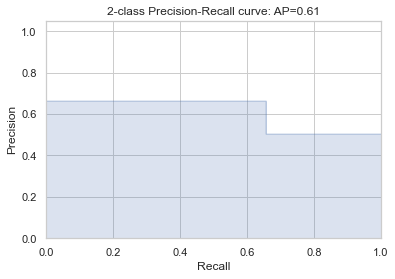

roc auc score: 0.6609097230003436



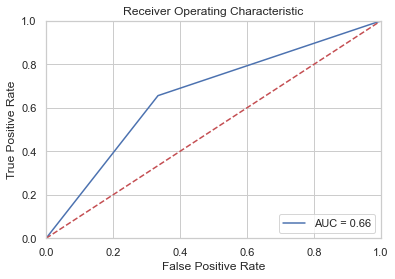

Classification Report: 
               precision    recall  f1-score   support

           0       0.66      0.67      0.66      3263
           1       0.67      0.66      0.66      3304

    accuracy                           0.66      6567
   macro avg       0.66      0.66      0.66      6567
weighted avg       0.66      0.66      0.66      6567


Confusion Matrix: 
 [[2172 1091]
 [1136 2168]]

End of validation Result



/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


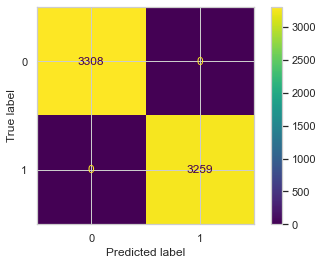

In [8]:
# classification report
clf_score(final_model, X_train, y_train, X_test, y_test, train=False)

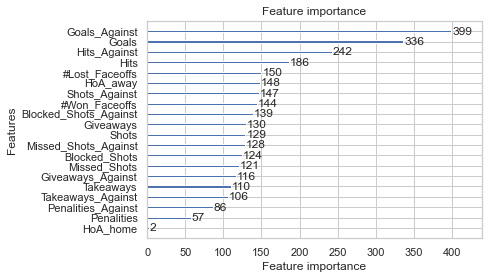

In [9]:
# plot feature importance
lgb.plot_importance(final_model)
plt.show()

/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


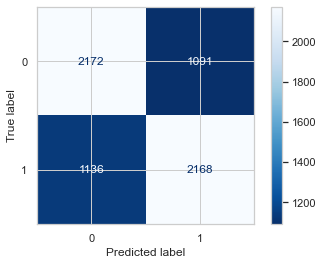

In [10]:
metrics.plot_confusion_matrix(final_model,X_test,y_test,cmap='Blues_r')

In [11]:
print(metrics.classification_report(y_test,final_model.predict(X_test)))

              precision    recall  f1-score   support

           0       0.66      0.67      0.66      3263
           1       0.67      0.66      0.66      3304

    accuracy                           0.66      6567
   macro avg       0.66      0.66      0.66      6567
weighted avg       0.66      0.66      0.66      6567



## Section 2.) SportsRadar API Retrieval and generation of probabilites

In [12]:
# Get todays date
today = date.today()

# dd/mm/YY
Day = today.strftime("%d")
Month = today.strftime("%m")
Year = today.strftime("%Y")
today = date.today()
print("Today's date:", today)

# Get API info
response = requests.get(("https://api.sportradar.us/nhl/trial/v7/en/games/{Year}/{Month}/{Day}/schedule.json?api_key=sa8b3wuwy549qwy6jw6srsgv").format(Day=14, Month = Month, Year = Year))

# Set response as json
x = response.json()

# Print API info
def getrs(obj):
    Todays_Schedule = []
    Todays_Schedule = pd.DataFrame([],columns = ["Game ID","Home Team",'Home Team ID',"Away Team","Away Team ID","Start Time"])
    q = len(obj["games"])
    for i in range(q):
            GID = obj["games"][i]["id"]
            H = obj['games'][i]['home']['name']
            Hid = obj['games'][i]['home']['id']
            A = obj['games'][i]['away']['name']
            Aid = obj['games'][i]['away']['id']
            PD = obj['games'][i]['scheduled']
            PD = re.search('T(.+?)Z',PD)
            if PD:
                found = PD.group(1)
            format = "%H:%M:%S"
            d = datetime.strptime(found,format) - timedelta(hours=4)
            d = d.strftime("%H:%M:%S")
            PD = d
            temp_df = [GID,H,Hid,A,Aid,PD]
            a_series = pd.Series(temp_df,index = Todays_Schedule.columns)
            Todays_Schedule = Todays_Schedule.append(a_series, ignore_index=True)
    return Todays_Schedule
data=getrs(x)
data.head(20)

Today's date: 2022-04-15


,Game ID,Home Team,Home Team ID,Away Team,Away Team ID,Start Time
0,0c37466c-fb04-4885-84b9-551ad7d59b6a,Buffalo Sabres,4416d559-0f24-11e2-8525-18a905767e44,St. Louis Blues,441660ea-0f24-11e2-8525-18a905767e44,19:00:00
1,1d106ed5-c01f-4d89-b036-32fd131d2dd2,Boston Bruins,4416ba1a-0f24-11e2-8525-18a905767e44,Ottawa Senators,4416f5e2-0f24-11e2-8525-18a905767e44,19:00:00
2,486d0a94-0883-47fc-87c4-4ec3c013d0b0,Tampa Bay Lightning,4417d3cb-0f24-11e2-8525-18a905767e44,Anaheim Ducks,441862de-0f24-11e2-8525-18a905767e44,19:00:00
3,6dd80f5e-1bea-48a5-8745-c8616d5b34c4,Carolina Hurricanes,44182a9d-0f24-11e2-8525-18a905767e44,Detroit Red Wings,44169bb9-0f24-11e2-8525-18a905767e44,19:00:00
4,72e23ab5-8255-441e-885e-33676199ecbe,Toronto Maple Leafs,441730a9-0f24-11e2-8525-18a905767e44,Washington Capitals,4417eede-0f24-11e2-8525-18a905767e44,19:00:00
5,8ee4837b-7fa2-4ee8-9319-1da3a7cea18c,Pittsburgh Penguins,4417b7d7-0f24-11e2-8525-18a905767e44,New York Islanders,441766b9-0f24-11e2-8525-18a905767e44,19:00:00
6,1493b1e8-32d7-4a41-bcbb-c1eb50907451,Dallas Stars,44157522-0f24-11e2-8525-18a905767e44,Minnesota Wild,4416091c-0f24-11e2-8525-18a905767e44,20:00:00
7,75c42870-0eaa-42d0-82b5-cd8ab73a6af6,Nashville Predators,441643b7-0f24-11e2-8525-18a905767e44,Edmonton Oilers,4415ea6c-0f24-11e2-8525-18a905767e44,20:00:00
8,bd5da7d2-f51c-4d8d-a7c6-999990a79080,Chicago Blackhawks,4416272f-0f24-11e2-8525-18a905767e44,San Jose Sharks,44155909-0f24-11e2-8525-18a905767e44,20:30:00
9,68e5bb25-3c01-46fb-99d5-0cb0b2003dd8,Colorado Avalanche,4415ce44-0f24-11e2-8525-18a905767e44,New Jersey Devils,44174b0c-0f24-11e2-8525-18a905767e44,21:00:00


In [13]:
# Define function to generate stats from the first period of play
def Game_Home_Team_Stats(game_id,home_team_id,game_time):
    ts = 0
    tsa = 0
    go = 0
    goa = 0
    t = 0
    ta = 0
    h = 0
    ha = 0
    bs = 0
    bsa = 0
    gi = 0
    gia = 0
    ms = 0
    msa = 0
    p = 0
    pa = 0
    tfw = 0
    tfl = 0
    away = 0
    home = 0
    now = datetime.now()
    current_time = now.strftime("%H:%M:%S")
    if current_time < game_time:
        pass
    else:
        response = requests.get(("https://api.sportradar.us/nhl/trial/v7/en/games/{obj}/pbp.json?api_key=sa8b3wuwy549qwy6jw6srsgv").format(obj = game_id))
        x = response.json()
        y = len(x['periods'][0]['events'])
        htc = x['home']['id']
        Team_Name = x['home']['name']
        Away_Name = x['away']['name']
        if htc == home_team_id:
            home = 1
        else:
            away = 1
        for i in range(y):
            j = x['periods'][0]['events'][i]['event_type']
            if j == 'faceoff':
                team_id = x['periods'][0]['events'][i]['attribution']['id']
                if team_id == home_team_id:
                        tfw = tfw + 1
                else:
                        tfl = tfl + 1
            elif j == 'goal':
                team_id = x['periods'][0]['events'][i]['attribution']['id']
                if team_id == home_team_id:
                        go = go + 1
                else:
                    goa = goa + 1
            elif j == 'penalty':
                team_id = x['periods'][0]['events'][i]['attribution']['id']
                if team_id == home_team_id:
                    p = p + 1
                else:
                    pa = pa + 1
            elif j == 'shotmissed' and 'blocked' in x['periods'][0]['events'][i]['description']:
                team_id = x['periods'][0]['events'][i]['attribution']['id']
                if team_id == home_team_id:
                        bs = bs + 1
                else:
                        bsa = bsa + 1
            elif j == 'shotmissed' and 'missed' in x['periods'][0]['events'][i]['description']:
                team_id = x['periods'][0]['events'][i]['attribution']['id']
                if team_id == home_team_id:
                        ms = ms + 1
                else:
                        msa = msa + 1
            elif j == 'giveaway':
                team_id = x['periods'][0]['events'][i]['attribution']['id']
                if team_id == home_team_id:
                    gi = gi + 1
                else:
                    gia = gia + 1
            elif j == 'hit':
                team_id = x['periods'][0]['events'][i]['attribution']['id']
                if team_id == home_team_id:
                    h = h + 1
                else:
                    ha = ha + 1
            elif j == 'takeaway':
                team_id = x['periods'][0]['events'][i]['attribution']['id']
                if team_id == home_team_id:
                    t = t + 1
                else:
                    ta = ta + 1
            elif 'shot' in j:
                team_id = x['periods'][0]['events'][i]['attribution']['id']
                if team_id == home_team_id:
                    ts = ts + 1
                else:
                    tsa = tsa + 1
            else:
                pass
            d = {"Team_Name":[Team_Name],"shots": [ts], "shots_against": [tsa],"goals":[go],"goals_against":[goa],"takeaways":[t],"takeaways_against":[ta],"hits":[h],"hits_against":[ha],"blockedShots":[bs],"blockedShots_against":[bsa],"giveaways":[gi],"giveaways_against":[gia],"missedShots":[ms],"missedShots_against":[msa],"penalties":[p],"penalties_against":[pa],"#Won Faceoffs":[tfw],"#Lost Faceoffs":[tfl],'HoA_away':[away],'HoA_home':[home]}
            da = {"Team_Name":[Away_Name],"shots": [tsa], "shots_against": [ts],"goals":[goa],"goals_against":[go],"takeaways":[ta],"takeaways_against":[t],"hits":[ha],"hits_against":[h],"blockedShots":[bsa],"blockedShots_against":[bs],"giveaways":[gia],"giveaways_against":[gi],"missedShots":[msa],"missedShots_against":[ms],"penalties":[pa],"penalties_against":[p],"#Won Faceoffs":[tfl],"#Lost Faceoffs":[tfw],'HoA_away':[home],'HoA_home':[away]}
            Home_Team_Stats = pd.DataFrame(d)
            Away_Team_Stats = pd.DataFrame(da)
            #series_obj = pd.Series(da)
            # Add a series as a row to the dataframe  
            All_Team_Stats = Home_Team_Stats.append(Away_Team_Stats,ignore_index=True)
        return All_Team_Stats
    
# Define function that takes tonights schedule (containing the nessecary Unique Id's) to gather the correct statistics from sportsradar
def get_game_stats(obj):
    c = ["Team_Name","shots", "shots_against","goals","goals_against","takeaways","takeaways_against","hits","hits_against","blockedShots","blockedShots_against","giveaways","giveaways_against","missedShots","missedShots_against","penalties","penalties_against","#Won Faceoffs","#Lost Faceoffs",'HoA_away','HoA_home']
    Tonights_games_stats = pd.DataFrame([],columns = c)
    r = len(obj['Game ID'])
    for i in range(r):
        game_id = obj['Game ID'][i]
        home_team_id = obj['Home Team ID'][i]
        game_start = obj['Start Time'][i]
        temp_df = Game_Home_Team_Stats(game_id,home_team_id,game_start)
        Tonights_games_stats = Tonights_games_stats.append(temp_df,ignore_index = True)
    return Tonights_games_stats

# Define function that inserts statistics for all of tonights teams into LGBMmodel
def tonights_bets(obj):
    m = len(obj)
    for i in range(m):
        Game_y_pred = final_model.predict(X_Game_test)
        prediction = [round(value) for value in Game_y_pred]
        print(prediction)
        probability = final_model.predict_proba(X_Game_test)
        print(probability)
tonights_data=get_game_stats(data)

# Generate Predictions from LGBMmodel
m = len(tonights_data)
y = tonights_data.pop('Team_Name')
for i in range(m):
    x_value = tonights_data.iloc[i]
    test = np.array([x_value])
    x_value = test.reshape(1, -1)
    Game_y_pred = final_model.predict(x_value)
    prediction = [round(value) for value in Game_y_pred]
    probability = final_model.predict_proba(x_value)
    if prediction[0] != 1:
        print("The "+y[i]+" are projected to lose.")
        print("Current odds are "+str(round((probability[0][0])*100,2))+"%"+" to lose and only "+str(round((probability[0][1])*100,2))+"%"+" to win."+'\n')
    else:
        print("The "+y[i]+" are projected to win.")
        print("Current odds are "+str(round((probability[0][1])*100,2))+"%"+" to win and "+str(round((probability[0][0])*100,2))+"%"+ " to lose."+'\n')


# When modeling both the home team and away team, there seems to be, on average a %4 difference between
# the home team and away teams respective odds. I believe this is due to LGBMmodel but because the difference
# is minor, I don't think its a problem for us. 

## Section 3.) Unit Testing and Data Drift Detection

In [ ]:
pickled_model = pickle.load(open(r'C:\Users\louis\OneDrive - McGill University\MMA Winter 2021 Notes\INSY695\classifier.pkl', 'rb'))
class TestModel(unittest.TestCase):
    
    
    def test_model_predictions(self):
        """
        Test to see if pickled model la²bel prediction = 1 OR = 0
        Test to see if pickled model probability prediction in [0,1]
        """
        fake_data = [[30,5,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0]]
        
        label_pred = pickled_model.predict(fake_data)
        proba_pred = pickled_model.predict_proba(fake_data)
        
        self.assertTrue( label_pred[0] == 0 | label_pred[0] == 1)
        self.assertTrue( np.max(proba_pred) < 1 & np.min(proba_pred) > 1)

In [32]:
df.dtypes

Shots                    float64
Shots_Against            float64
Goals                    float64
Goals_Against            float64
Takeaways                float64
Takeaways_Against        float64
Hits                     float64
Hits_Against             float64
Blocked Shots            float64
Blocked Shots Against    float64
Giveaways                float64
Giveaways_Against        float64
Missed Shots             float64
Missed Shots_Against     float64
Penalities               float64
Penalities_Against       float64
#Won Faceoffs            float64
#Lost Faceoffs           float64
HoA_away                   int64
HoA_home                   int64
dtype: object

In [ ]:
#Get the feature names
feature_names = df.columns

#Split dataset into two
#Reference game contains all data minus last 20 games
X_ref = np.array(df.iloc[:-30,:])
#Test set has last 20 games
X_new = np.array(df.iloc[-30:,:])

#TabularDrift: K-S tests for num features, Chi-squared for categorical
cd = TabularDrift(p_val=0.05, x_ref = X_ref)

In [ ]:
#Predict general drift
preds = cd.predict(X_new, return_p_val=True, return_distance = True)
labels = ['No!', 'Yes!']
print('Drift? {}'.format(labels[preds['data']['is_drift']]))

#Predict the drift for each feature
fpreds = cd.predict(X_new, drift_type="feature", return_p_val=True, return_distance=True)

#Get drift per feature
for f in range(cd.n_features):
    stat = 'K-S'
    fname = feature_names[f]
    is_drift = fpreds['data']['is_drift'][f]
    stat_val, p_val = fpreds['data']['distance'][f], fpreds['data']['p_val'][f]
    print(f'{fname} -- Drift? {labels[is_drift]} -- {stat} {stat_val:.3f} -- p-value {p_val:.3f}')